# Manifold Learning

<h3><span style="color:blue">
NOTE:
In this code, all inputs and outputs are <i>column vectors</i>.<br/>
</span></h3>

In [1]:
%matplotlib notebook
# In other IDEs such as VS Code, the above may not work. Instead, you may have to use %matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Part 1.  Multidimensional Scaling

In [2]:
from sklearn.metrics.pairwise import euclidean_distances

# Helper functions & Datasets
from Code.optimization import gradient_descent
from Code.dataset import ten_city, synthetic_spiral

## * Classical MDS

### <span style="color:red">============= Assignment 1 =============</span>

In [3]:
#Assignment 1(a)
def cmds(X, n_dim, input_type='raw'):
    """
    Classical(linear) multidimensional scaling (MDS)
    
    Parameters
    ----------
    X: (d, n) array or (n,n) array
        input data. The data are placed in column-major order. 
        That is, samples are placed in the matrix (X) as column vectors
        d: dimension of points
        n: number of points
        
    n_dim: dimension of target space
    
    input_type: it indicates whether data are raw or distance
        - raw: raw data. (n,d) array. 
        - distance: precomputed distances between the data. (n,n) array.
    Returns
    -------
    Y: (n_dim, n) array. projected embeddings.
    evals: (n_dim) eigen values
    evecs: corresponding eigen vectors in column vectors
    """

    if input_type == 'distance':
        D = X
    elif input_type == 'raw':
        Xt = X.T
        D = euclidean_distances(Xt,Xt)
        
       #start from here

        # Centering matrix
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n

    # Compute the Gram matrix
    G = -0.5 * H @ (D ** 2) @ H

    # Eigen decomposition
    evals, evecs = np.linalg.eigh(G)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Select the top n_dim components
    evals = evals[:n_dim]
    evecs = evecs[:, :n_dim]

    # Select top n_dim dimensions
    et = evecs[:, :n_dim]
    Y = np.diag(np.sqrt(evals[:n_dim])) @ et.T
    
     #end
    
    return Y, evals, evecs

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T

n_dim = 3
Y_test, evals, evecs = cmds(X=test_data, n_dim=n_dim, input_type='raw')
print('%d-largest eigen values:'% n_dim)
print(evals)
print('Corresponding eigen vectors:\n', evecs.T)
print('Embedded coordinates:')
print(Y_test)

3-largest eigen values:
[58.77200526 10.152993    1.82500175]
Corresponding eigen vectors:
 [[-0.29850918 -0.29530012  0.86584461 -0.27203532]
 [-0.11970309  0.75346239  0.01262009 -0.6463794 ]
 [-0.80409169  0.30837033 -0.0124031   0.50812445]]
Embedded coordinates:
[[-2.28845802 -2.26385638  6.63781607 -2.08550168]
 [-0.38141906  2.4008146   0.04021235 -2.0596079 ]
 [-1.08626857  0.41658558 -0.01675568  0.68643867]]


In [4]:
# ten city dataset
flying_dist, city = ten_city()
flying_dist = flying_dist + flying_dist.T

2-largest eigenvalues: [9582144.29921687 1686820.18346485]
Corresponding eigenvectors:
[[-0.23219463 -0.11009922]
 [-0.1234228   0.26243133]
 [ 0.15558124  0.01946836]
 [-0.05216154 -0.44100732]
 [ 0.38886659 -0.30035985]
 [-0.366185   -0.44804271]
 [-0.34638486  0.39962554]
 [ 0.45892474 -0.08668867]
 [ 0.43344235  0.44637343]
 [-0.31646608  0.25829912]]


<IPython.core.display.Javascript object>


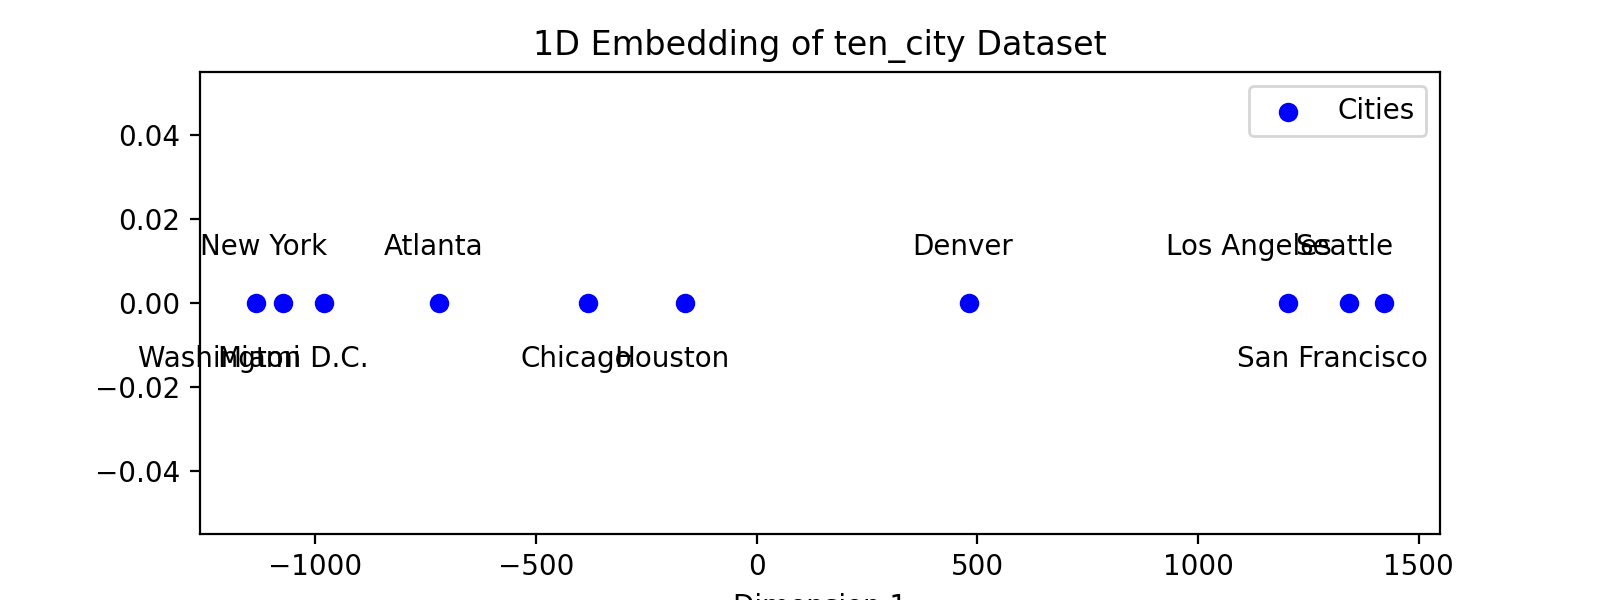

<IPython.core.display.Javascript object>


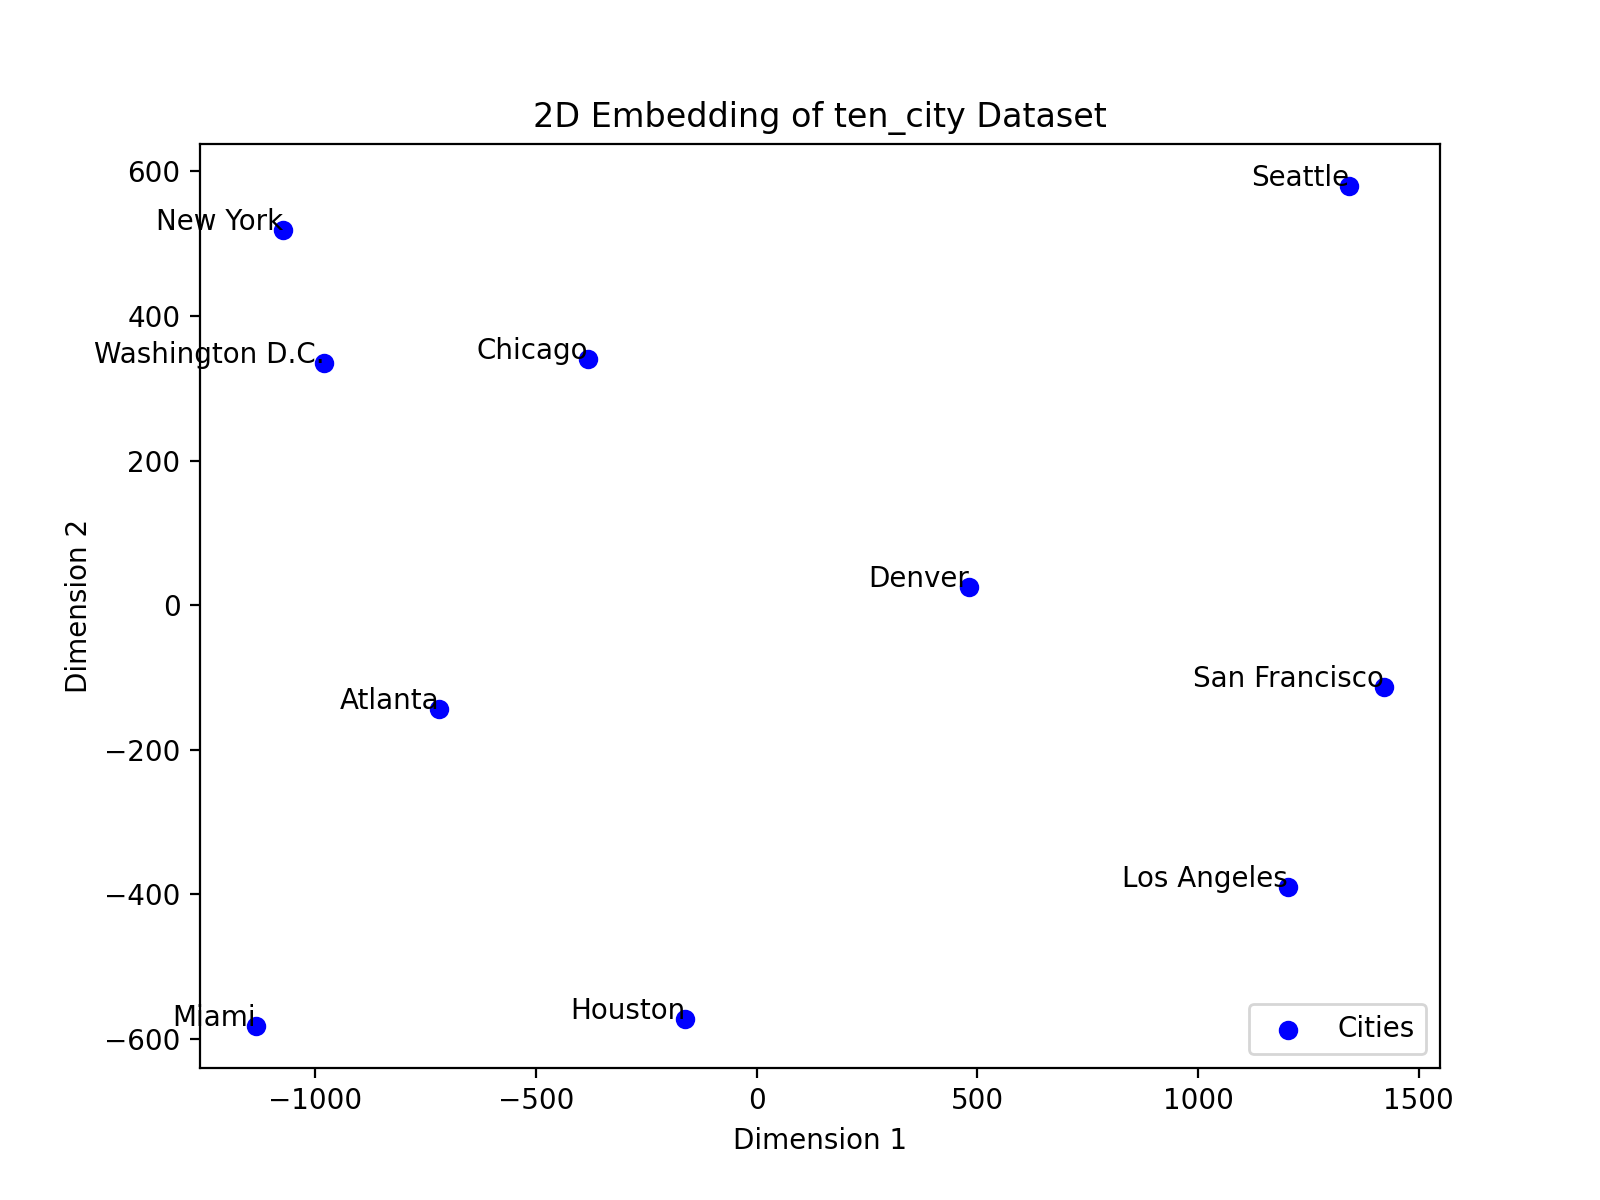

In [5]:
#Assignment 1(b)
n_dim = 2
Y_city, evals_city, evecs_city = cmds(X=flying_dist, n_dim=n_dim, input_type='distance')

# Report the first 2 largest eigenvalues and their corresponding eigenvectors
print(f'{n_dim}-largest eigenvalues:', evals_city)
print('Corresponding eigenvectors:')
print(evecs_city)


# Visualization (1D embeddings)
plt.figure(figsize=(8, 3))  # Adjust the aspect ratio for 1D plot

# Plot 1D embedding using the first column of Y_city
plt.scatter(Y_city[0, :], [0] * len(Y_city[0, :]), c='b', label='Cities')


for i, city_name in enumerate(city):
    if i % 2 == 0:
       
        plt.text(Y_city[0, i]+100, 0.01, city_name, ha='right', va='bottom')
    else:
       
        plt.text(Y_city[0, i]+100, -0.01, city_name, ha='right', va='top')
    

plt.xlabel('Dimension 1')
plt.title('1D Embedding of ten_city Dataset')
plt.legend()
plt.show()

# Visualization (2D embeddings)
plt.figure(figsize=(8, 6))

# Use columns as x and y coordinates for 2D plot
plt.scatter(Y_city[0,:], Y_city[1,:], c='b', label='Cities')

# Annotate each city
for i in range(Y_city.shape[1]):
    plt.text(Y_city[0,i], Y_city[1,i], city[i], fontsize=10, ha='right')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embedding of ten_city Dataset')
plt.legend()
plt.show()


### <span style="color:red">=========== End of Assignment 1 ===========</span>

## * Stress-based MDS

### <span style="color:red">============= Assignment 2 =============</span>

In [6]:
def loss_sammon(D, y):
    """
    Loss function (stress) - Sammon
    
    Parameters
    ----------
    D: (n,n) array. distance matrix in original space
        This is a symmetric matrix.
    y: (d,n) array
        d is the dimensionality of target space.
        n is the number of points.
        
    Returns
    -------
    stress: scalar. stress
    """
    n = D.shape[0]
    stress = 0.0
    dist_y=euclidean_distances(y.T)
    
    factor_norm = np.sum(D[np.triu_indices(n, k=1)]) #for nomalization factor
    
    for i in range(n):
        for j in range(i+1, n):  
            
            # Avoid division by zero (handle cases where D_ij is zero or very small)
            if D[i, j] == 0:
                continue
            
            # Compute the stress contribution for this pair
            stress_contribution = (dist_y[i, j] - D[i, j])**2 / D[i, j]
            stress += stress_contribution
    
    stress/=factor_norm
    
    return stress

def grad_sammon(D, y):
    """
    Gradient function (first derivative) - Sammonn_dim
    
    Parameters
    ----------
    D: (n,n) array. distance matrix in original space
        This is a symmetric matrix.
    y: (d,n) array
        d is the dimensionality of target space.
        n is the number of points.
        
    Returns
    -------
    g: (d,n) array.
        Gradient matrix.
        d is the dimensionality of target space.
        n is the number of points.
    """
    n = D.shape[0]
    g = np.zeros_like(y,dtype=np.float64)
    
    dist_y=euclidean_distances(y.T)
    factor_norm = np.sum(D[np.triu_indices(n, k=1)])
    
    for i in range(n):
        for j in range(n):  
            # avoid 0
            if D[i, j]> 0 and i!=j:
                # Compute the factor for the gradient
                factor =2* (dist_y[i, j] - D[i, j] ) * (y[:, i] - y[:, j])/ (D[i, j] * dist_y[i, j])
            
                # Compute the gradient for each dimension (k)
                g[:, i] += factor
                g[:, j] -= factor
            
    g/=factor_norm
    
    return g

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T
D = euclidean_distances(test_data.T, test_data.T)
y = np.array([[1,0],[1,1],[0,1],[0,0]]).T
loss = loss_sammon(D, y)
gradient = grad_sammon(D, y)
print(loss)
print(gradient)

0.6771513964361345
[[-0.1273606  -0.14744318  0.15950595  0.11529784]
 [ 0.13722784 -0.12516508 -0.15922223  0.14715947]]


### <span style="color:red">=========== End of Assignment 2 ===========</span>

The following function provided for students is used to do Assignment 3.

In [7]:
def stress_based_mds(x, n_dim, loss_f, grad_f, input_type='raw', 
                     lr=0.5, tol=1e-9, max_iter=6000):
    """
    Stress-based MDS
    
    Parameters
    ----------
    x: (d,n) array or (n,n) array
        If it is raw data -> (d,n) array
        otherwise, (n,n) array (distance matrix)
        n is the number of points
        d is the dimensionality of original space
    n_dim: dimensionality of target space
    loss_f: loss function
    grad_f: gradient function
    input_type: 'raw' or 'distance'
    init: initialisation method
        random: Initial y is set randomly
        fixed: Initial y is set by pre-defined values
    max_iter: maximum iteration of optimization
    
    Returns
    -------
    y: (n_dim,n) array. Embedded coordinates in target space
    losses: (max_iter,) History of stress
    """

    # obtain distance
    if input_type == 'raw':
        x_t = x.T
        D = euclidean_distances(x_t, x_t)
    elif input_type == 'distance':
        D = x
    else:
        raise ValueError('inappropriate input_type')
    
    # Remaining initialisation
    N = x.shape[1]

    np.random.seed(10)
    # Initialise y randomly
    y = np.random.normal(0.0,1.0,[n_dim,N])

    # calculate optimal solution (embedded coordinates)
    y, losses = gradient_descent(D, y, loss_f, grad_f, lr, tol, max_iter)
    
    return y, losses

### <span style="color:red">=========== Assignment 3 ===========</span>

<IPython.core.display.Javascript object>


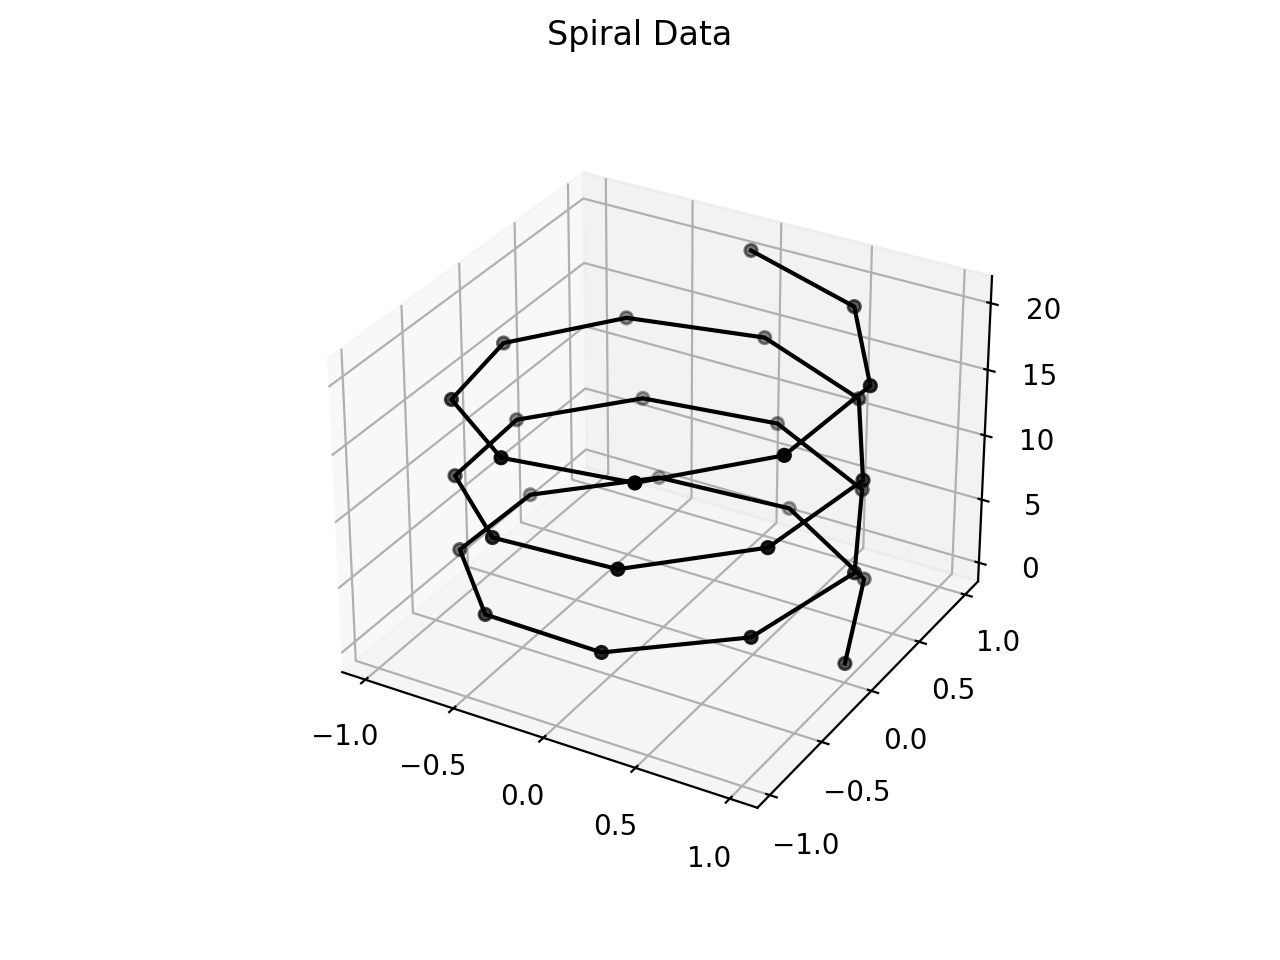

In [8]:
X_spiral = synthetic_spiral()

fig_spiral = plt.figure()
fig_spiral.suptitle('Spiral Data')

# Add 3d scatter plot
ax = fig_spiral.add_subplot(projection='3d')
ax.scatter(X_spiral[0,:], X_spiral[1,:], X_spiral[2,:], c='k')
ax.plot(X_spiral[0,:], X_spiral[1,:], X_spiral[2,:], c='k');

Testing: lr=0.1, tol=0.001
iter: 5999, stress: 0.22866292001497468	

Testing: lr=0.1, tol=1e-05
iter: 5999, stress: 0.22866292001497468	

Testing: lr=0.1, tol=1e-09
iter: 5999, stress: 0.22866292001497468	

Testing: lr=0.5, tol=0.001
iter: 5999, stress: 0.0018086994072512995	

Testing: lr=0.5, tol=1e-05
iter: 5999, stress: 0.0018086994072512995	

Testing: lr=0.5, tol=1e-09
iter: 5999, stress: 0.0018086994072512995	

Testing: lr=1, tol=0.001
iter: 5999, stress: 0.0016254187702486815	

Testing: lr=1, tol=1e-05
iter: 5999, stress: 0.0016254187702486815	

Testing: lr=1, tol=1e-09
iter: 5999, stress: 0.0016254187702486815	

Testing: lr=3, tol=0.001
iter: 5999, stress: 0.0013887080875886017	

Testing: lr=3, tol=1e-05
iter: 5999, stress: 0.0013887080875886017	

Testing: lr=3, tol=1e-09
iter: 5999, stress: 0.0013887080875886017	

best_lr: 3
best_tol: 0.001
Final iteration: 6000
Final stress value: 0.0013887080875886017


<IPython.core.display.Javascript object>


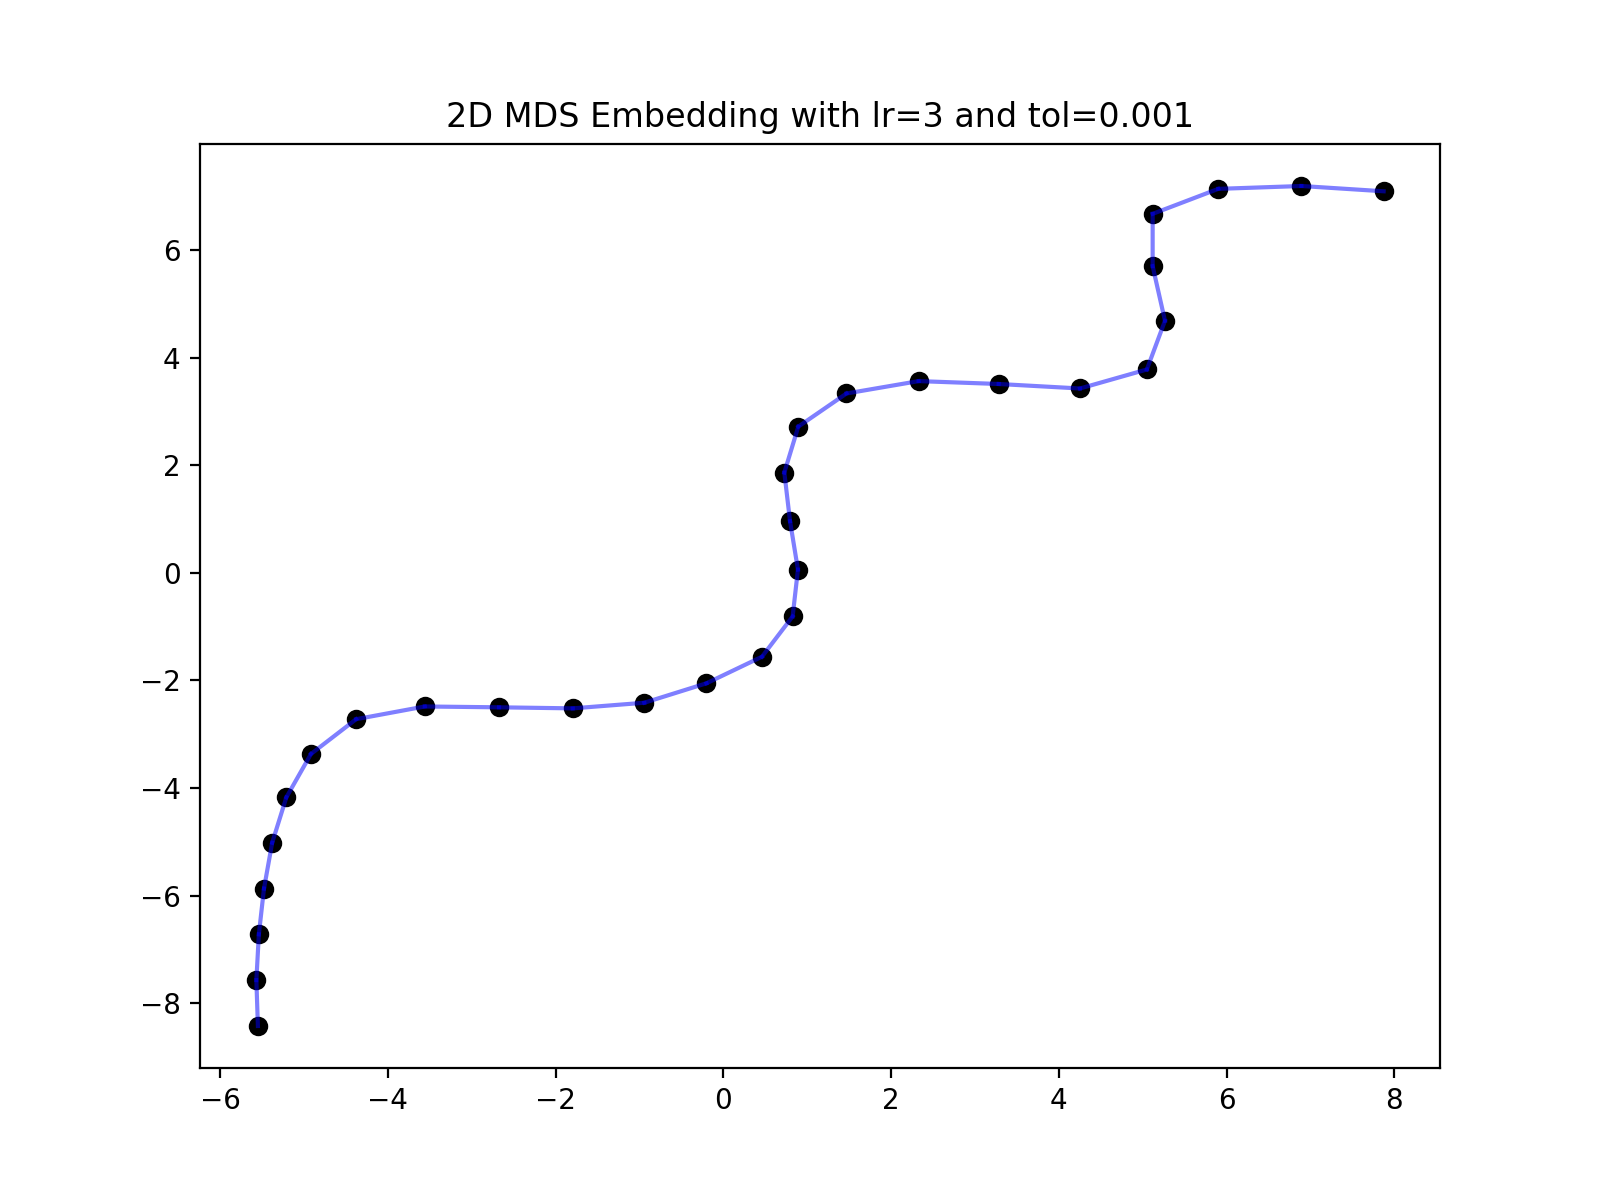

In [9]:
#(a) Report the Optimal Hyperparameters

# Define the learning rate and tolerance for the test
learning_rates = [0.1,0.5,1,3]
tolerances = [1e-3, 1e-5, 1e-9]
max_iter = 6000  # Maximum number of iterations
n_dim = 2  # We want to go down to two dimensions

# Define a function to test different hyperparameters
def test_hyperparameters(X_spiral, lr_values, tol_values):
    best_loss = float('inf')
    best_lr = None
    best_tol = None
    best_y = None
    best_losses = None
    
    for lr in lr_values:
        for tol in tol_values:
            print(f"Testing: lr={lr}, tol={tol}")
            # Run MDS optimization
            y, losses = stress_based_mds(X_spiral, n_dim=2, loss_f=loss_sammon, grad_f=grad_sammon, 
                                          input_type='raw', lr=lr, tol=tol, max_iter=max_iter)
            
            # If the current loss is less than the optimal loss, the optimal parameters are updated
            if losses[-1] < best_loss:
                best_loss = losses[-1]
                best_lr = lr
                best_tol = tol
                best_y = y
                best_losses = losses
                
    return best_lr, best_tol, best_y, best_losses

# Find the best hyperparameters
best_lr, best_tol, best_y, best_losses = test_hyperparameters(X_spiral, learning_rates, tolerances)

print(f"best_lr: {best_lr}")
print(f"best_tol: {best_tol}")

# Print last iteration count and final stress value
final_iter = len(best_losses)  # Last iteration count
final_stress = best_losses[-1]  # Final stress value

print(f"Final iteration: {final_iter}")
print(f"Final stress value: {final_stress}")

#(c) Display 2D Embedding Results with Optimal Parameters
plt.figure(figsize=(8, 6))
plt.scatter(best_y[0, :], best_y[1, :], c='k')

# Connect the points with lines (based on their order)
# We will connect consecutive points as an example
for i in range(best_y.shape[1] - 1):
    plt.plot([best_y[0, i], best_y[0, i + 1]], [best_y[1, i], best_y[1, i + 1]], 'b-', alpha=0.5)  # Lines connecting points

plt.title(f"2D MDS Embedding with lr={best_lr} and tol={best_tol}")
plt.show()


 【Assignment 3-(b)】 Justification for Optimal Hyperparameters：
 
To identify the optimal hyperparameters, we conducted a grid search on the spiral dataset by testing combinations of learning rates (lr) and tolerance values (tol). We evaluated a range of lr values [0.1, 0.5, 1, 3] and tol values [1e-3, 1e-5, 1e-9], running the stress_based_mds function for a fixed maximum of 6000 iterations for each pair. The final stress value was used as the key metric, as lower stress indicates a closer match between pairwise distances in the original high-dimensional space and the reduced 2D space. The results showed that when lr=0.1, the stress converged to 0.2287 across all tol values, suggesting insufficient optimization. Increasing lr to 0.5 significantly reduced stress to 0.0018, and further increasing lr to 1 reduced it slightly to 0.0016. At lr=3, the stress was minimized to 0.00139, indicating the best optimization performance. Tolerance values had less impact on the final stress, but tol=0.001 offered
computational efficiency by enabling early termination. Therefore, the optimal hyperparameters are lr=3, achieving the lowest stress value (0.00139), and tol=0.001, balancing efficiency and reliability.


### <span style="color:red">=========== End of Assignment 3 ===========</span>

## Part 2. Isometric Feature Mapping (ISOMAP)

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
from Code.helpers import VIS_Shortest_path_2d, ImageViewer

### <span style="color:red">============= Assignment 4 =============</span>

In [11]:
def fixed_radius_distance(X, epsilon):
    """
    Calculate epsilon-NN
    
    Parameters
    ----------
    X: (d,n) array, where n is the number of points and d is its dimension
    epsilon: criterion of selecting neighbors
        Select points as its neighbours if distance < epsilon
        
    Returns
    -------
    nbrs_dist: (n,k*) array
        It is filled with distances with neighbors. 
        In each row, k* varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    nbrs_idx: (n,k*) array
        It is filled with the indices of neighbors. 
        In each row, k* varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    """
    n_points = X.shape[1]
    nbrs_dist = []
    nbrs_idx = []

    dist_matrix = euclidean_distances(X.T, X.T)  # Compute pairwise distances

    for i in range(n_points):
        mask = dist_matrix[i, :] < epsilon  # Points within radius
        mask[i] = False  # Exclude self
        nbrs_dist.append(dist_matrix[i, mask])
        nbrs_idx.append(np.where(mask)[0])

    return nbrs_dist, nbrs_idx

def nearest_neighbor_distance(X, n_neighbors):
    """
    Calculate K-NN
    
    Parameters
    ----------
    X: (d,n) array, where n is the number of points and d is its dimension
    n_neighbors: number of neighbors
        Select n_neighbors(k) nearest neighbors

    Returns
    -------
    dist: (n,k) array
        It is filled with distances with neighbors. 
        In each row, k varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    nbrs: (n,k) array
        It is filled with the indices of neighbors. 
        In each row, k varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    """
    n_points = X.shape[1]
    dist_matrix = euclidean_distances(X.T, X.T)  # Compute pairwise distances

    nbrs_dist = np.zeros((n_points, n_neighbors))  # Store distances
    nbrs_idx = np.zeros((n_points, n_neighbors), dtype=int)  # Store indices

    for i in range(n_points):
       
        indices = np.argsort(dist_matrix[i]) # Get nearest neighbors

        nbrs_idx[i] = indices[1:n_neighbors+1]
        nbrs_dist[i] = dist_matrix[i,nbrs_idx[i]]

    return nbrs_dist, nbrs_idx

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T
dist, idx = fixed_radius_distance(test_data, 9.1)
print(dist)
print(idx)

dist, idx = nearest_neighbor_distance(test_data, 2)
print(dist)
print(idx)

[array([3.16227766, 9.        , 2.44948974]), array([3.16227766, 4.47213595]), array([9., 9.]), array([2.44948974, 4.47213595, 9.        ])]
[array([1, 2, 3]), array([0, 3]), array([0, 3]), array([0, 1, 2])]
[[2.44948974 3.16227766]
 [3.16227766 4.47213595]
 [9.         9.        ]
 [2.44948974 4.47213595]]
[[3 1]
 [0 3]
 [0 3]
 [0 1]]


In [12]:
def isomap(x, n_components, n_neighbors=None, epsilon=None, dist_func=None, cmds_func=None):
    """
    ISOMAP
    
    Parameters
    ----------
    x: (d,n) array, where n is the number of points and n is its dimensionality.
    n_components: dimentionality of target space
    n_neighbors: the number of neighourhood
    epsilon: fixed radius
    dist_func: function for calculating distance matrix
    
    Returns
    -------
    Y: (d,n) array. Embedded coordinates from cmds in Step 3.
    dist_mat: (n,n)array. Distance matrix made in Step 1.
    predecessors: predecessors from "shortest_path" function in Step 2.
    """
    assert(cmds_func is not None)
    assert((epsilon is not None) or (n_neighbors is not None))

    n_points = x.shape[1]

    # Step 1.
    # find nearest neighbors to each sample with the given condition
    if epsilon is not None:
        nbrs_dist, nbrs_idx = fixed_radius_distance(x, epsilon)
    else:
        nbrs_dist, nbrs_idx = nearest_neighbor_distance(x, n_neighbors)

    # Create a graph with distances
    dist_mat = np.full((n_points, n_points), np.inf)
    for i in range(n_points):
        dist_mat[i, nbrs_idx[i]] = nbrs_dist[i]
    dist_mat = np.minimum(dist_mat, dist_mat.T)  # Ensure symmetry
    
    
    # Step 2.
    # Find shortest paths
    from scipy.sparse import csr_matrix
    from scipy.sparse.csgraph import shortest_path
    graph = csr_matrix(dist_mat)
    dist_mat, predecessors = shortest_path(graph, return_predecessors=True)


    # Step 3.
    # Apply cMDS
    Y, _, _ = cmds_func(dist_mat, n_components, input_type='distance')
    return Y, dist_mat, predecessors

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T
n_components = 2
n_neighbors = 2
Y_nn, dist_nn, predecessors_nn = isomap(test_data, 
                                            n_components, 
                                            n_neighbors=n_neighbors, 
                                            dist_func=nearest_neighbor_distance, 
                                            cmds_func=cmds)
print(Y_nn)
print(dist_nn)
print(predecessors_nn)

[[-1.53779536 -4.68615915  7.46351727 -1.23956276]
 [-0.54291307 -0.95571131 -0.39708534  1.89570972]]
[[ 0.          3.16227766  9.          2.44948974]
 [ 3.16227766  0.         12.16227766  4.47213595]
 [ 9.         12.16227766  0.          9.        ]
 [ 2.44948974  4.47213595  9.          0.        ]]
[[-9999     0     0     0]
 [    1 -9999     0     1]
 [    2     0 -9999     2]
 [    3     3     3 -9999]]


### Example with Swiss Roll

In [13]:
from sklearn.datasets import make_swiss_roll

n_points = 1000
data_s_roll, color = make_swiss_roll(n_points)
data_s_roll = data_s_roll.T

<IPython.core.display.Javascript object>


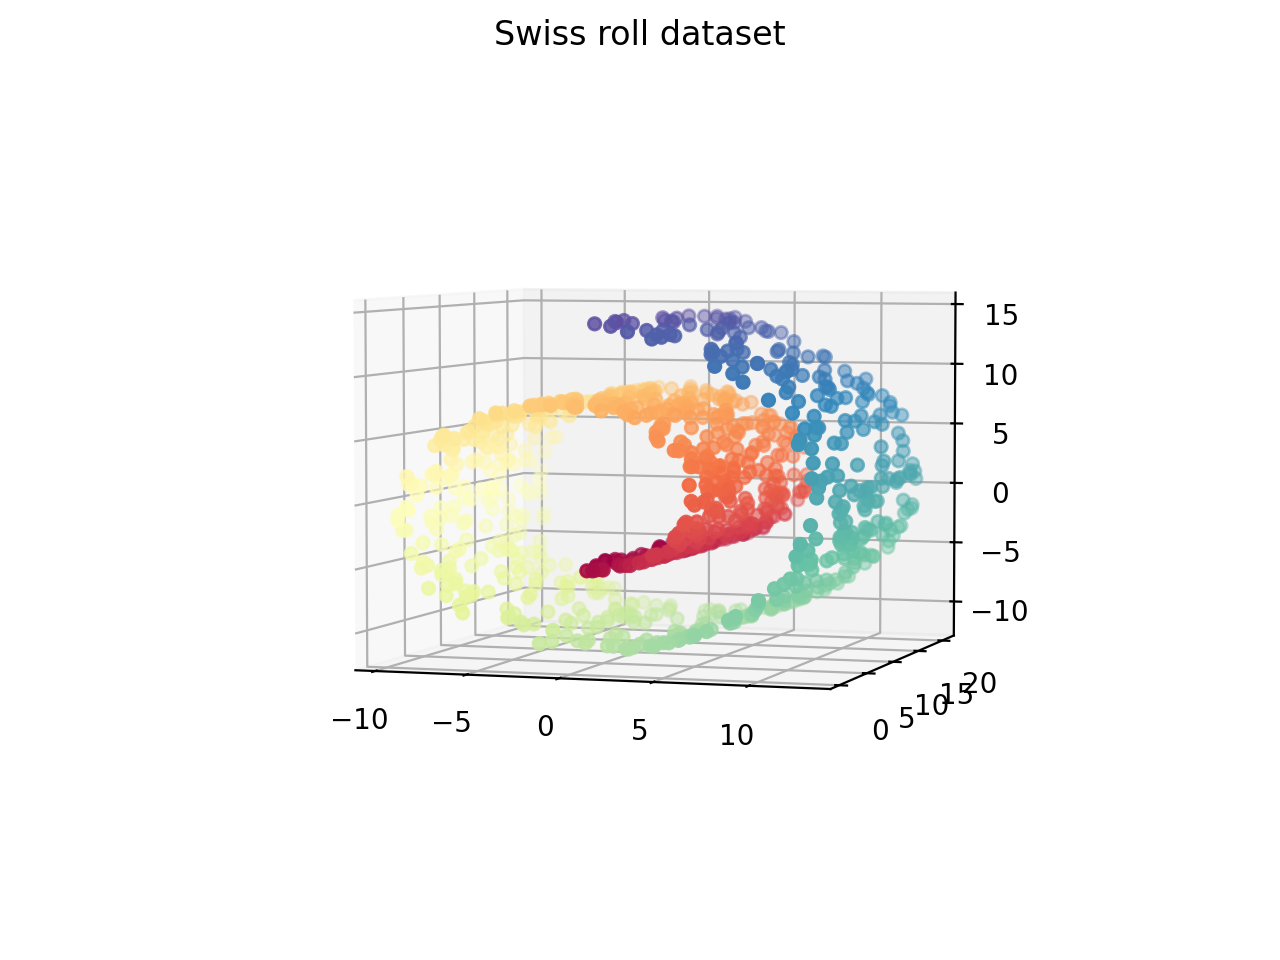

In [14]:
fig_swiss_roll = plt.figure()
fig_swiss_roll.suptitle("Swiss roll dataset")

# Add 3d scatter plot
ax = fig_swiss_roll.add_subplot(projection='3d')
ax.scatter(data_s_roll[0,:], data_s_roll[1,:], data_s_roll[2,:], c=color, 
           cmap=plt.cm.Spectral)
ax.view_init(4, -72);

<IPython.core.display.Javascript object>


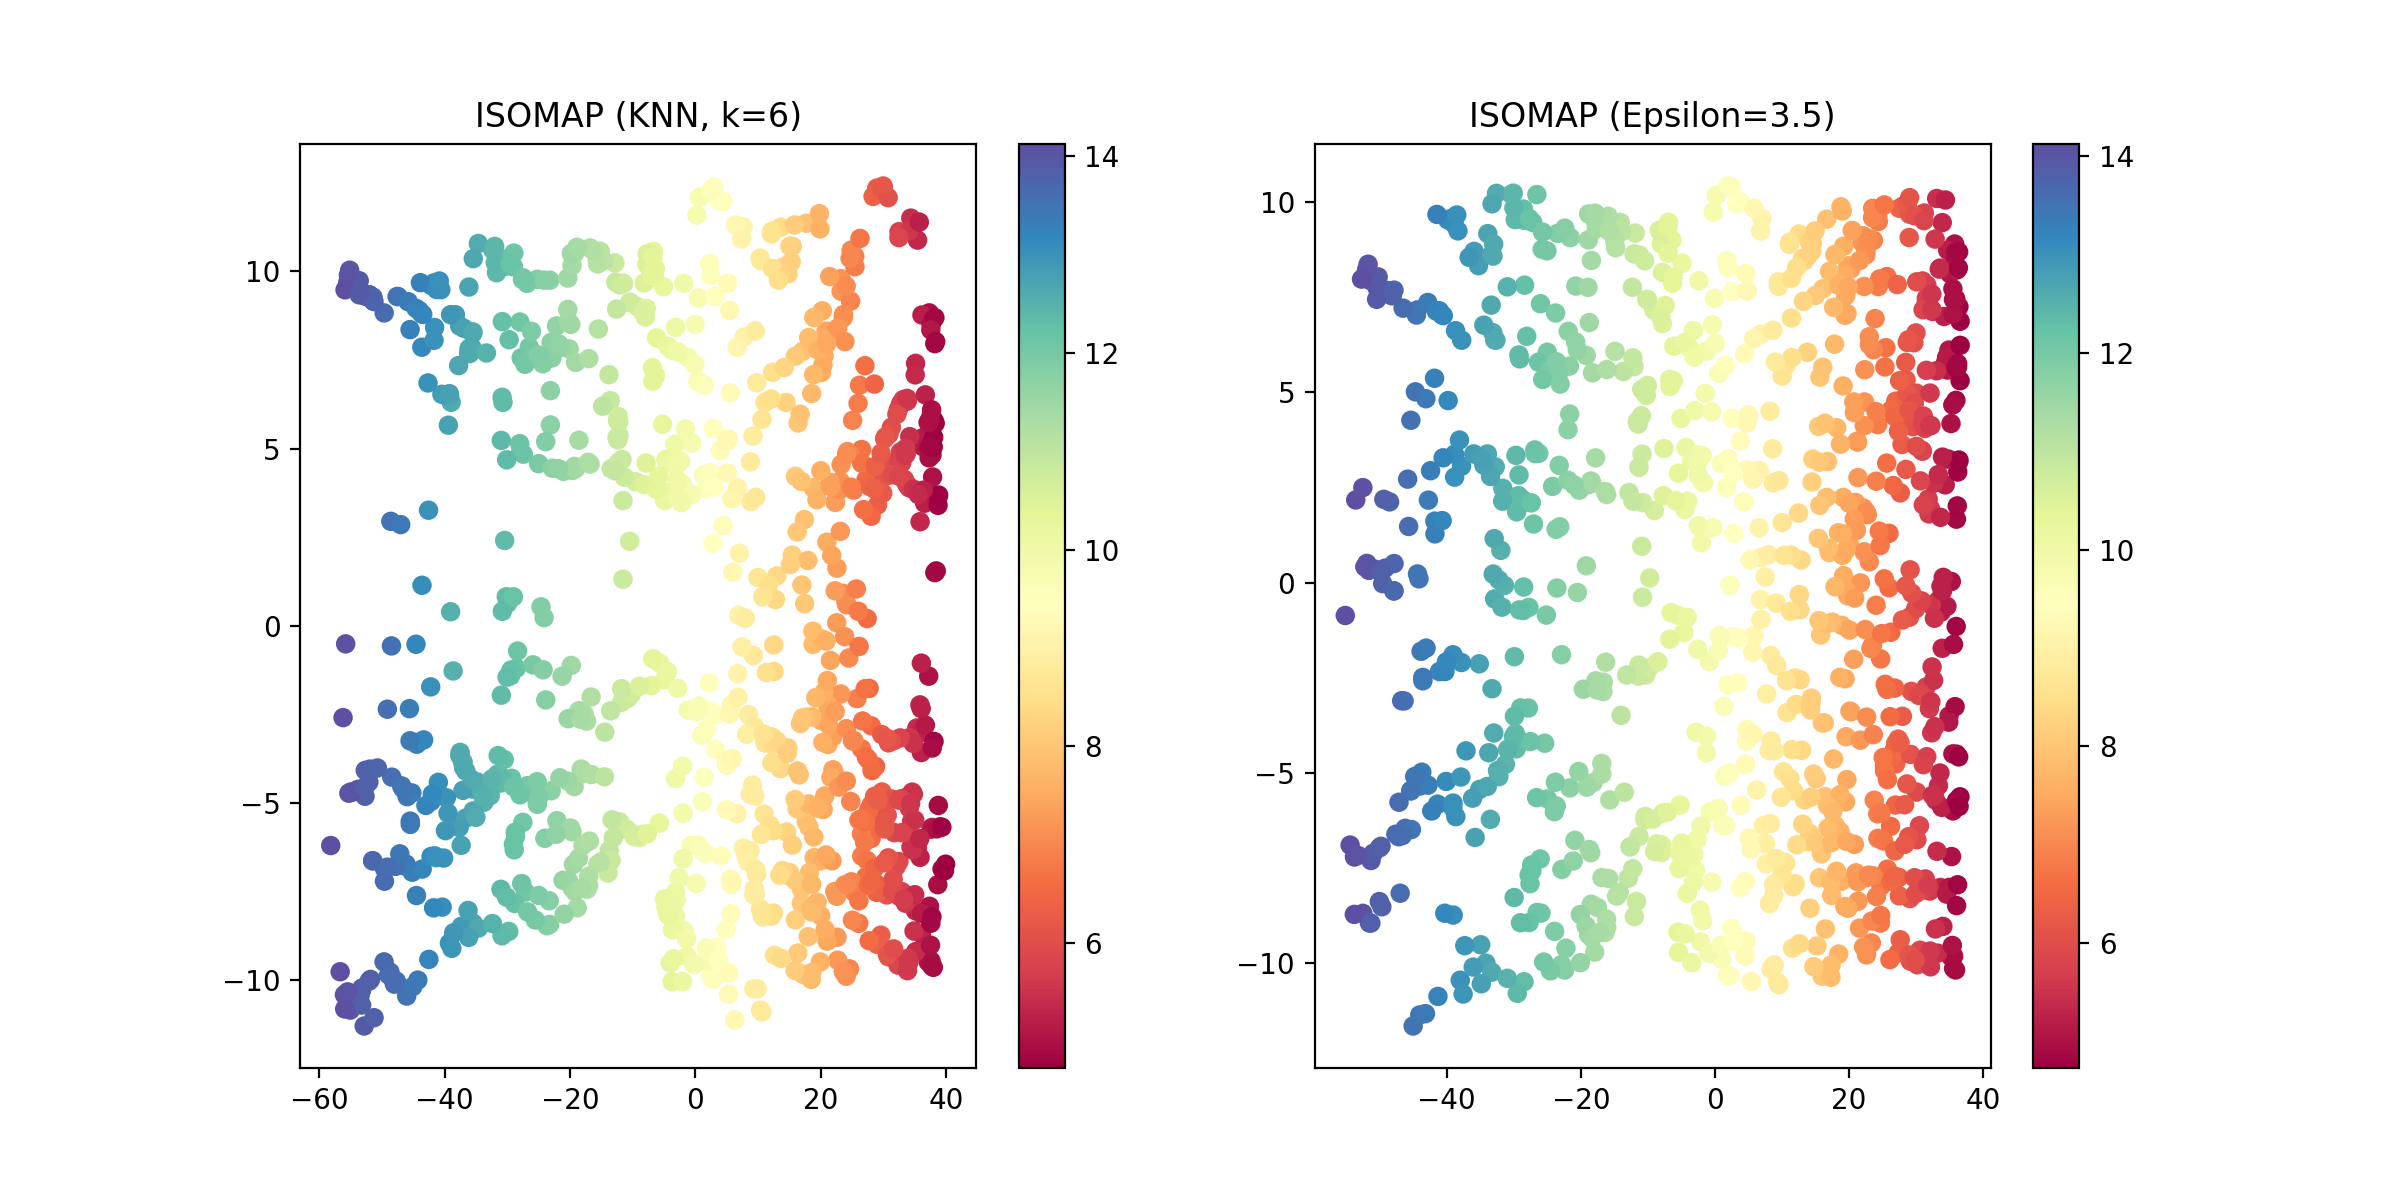

In [32]:
# ISOMAP results
k, epsilon = 6, 3.5
Y_k, _, _ = isomap(data_s_roll, 2, n_neighbors=k, dist_func=nearest_neighbor_distance, cmds_func=cmds)
Y_epsilon, _, _ = isomap(data_s_roll, 2, epsilon=epsilon, dist_func=fixed_radius_distance, cmds_func=cmds)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot KNN results
scatter1 = axs[0].scatter(Y_k[0,:], Y_k[1,:], c=color, cmap=plt.cm.Spectral)
axs[0].set_title(f"ISOMAP (KNN, k={k})")

# Plot Epsilon results
scatter2 = axs[1].scatter(Y_epsilon[0,:], Y_epsilon[1,:], c=color, cmap=plt.cm.Spectral)
axs[1].set_title(f"ISOMAP (Epsilon={epsilon})")

# Add color bar for better visualization
fig.colorbar(scatter1, ax=axs[0])
fig.colorbar(scatter2, ax=axs[1])

plt.show()

### <span style="color:red">=========== End of Assignment 4 ===========</span>
    
    
The following code is provided to do Assignment 5.
    

### Example with face data

In [16]:
from Code.dataset import face_tenenbaum


data_face = face_tenenbaum()
print(data_face.shape)
image_size = [64,64]

(4096, 698)


In [17]:
n_components = 2
n_neighbors = 6
Y_face, dist_face, predecessors_face = isomap(data_face, n_components, 
                                              n_neighbors=n_neighbors, 
                                              dist_func=nearest_neighbor_distance, 
                                              cmds_func=cmds)

### <span style="color:red">============= Assignment 5 =============</span>

#### Shortest path of specific two points

In [18]:
def get_shortest_path(predecessors, start_idx, end_idx):
    path = [end_idx]
    k = end_idx
    while predecessors[start_idx, k] != -9999:
        path.append(predecessors[start_idx, k])
        k = predecessors[start_idx, k]
    return path[::-1]

#### Path 1

<IPython.core.display.Javascript object>


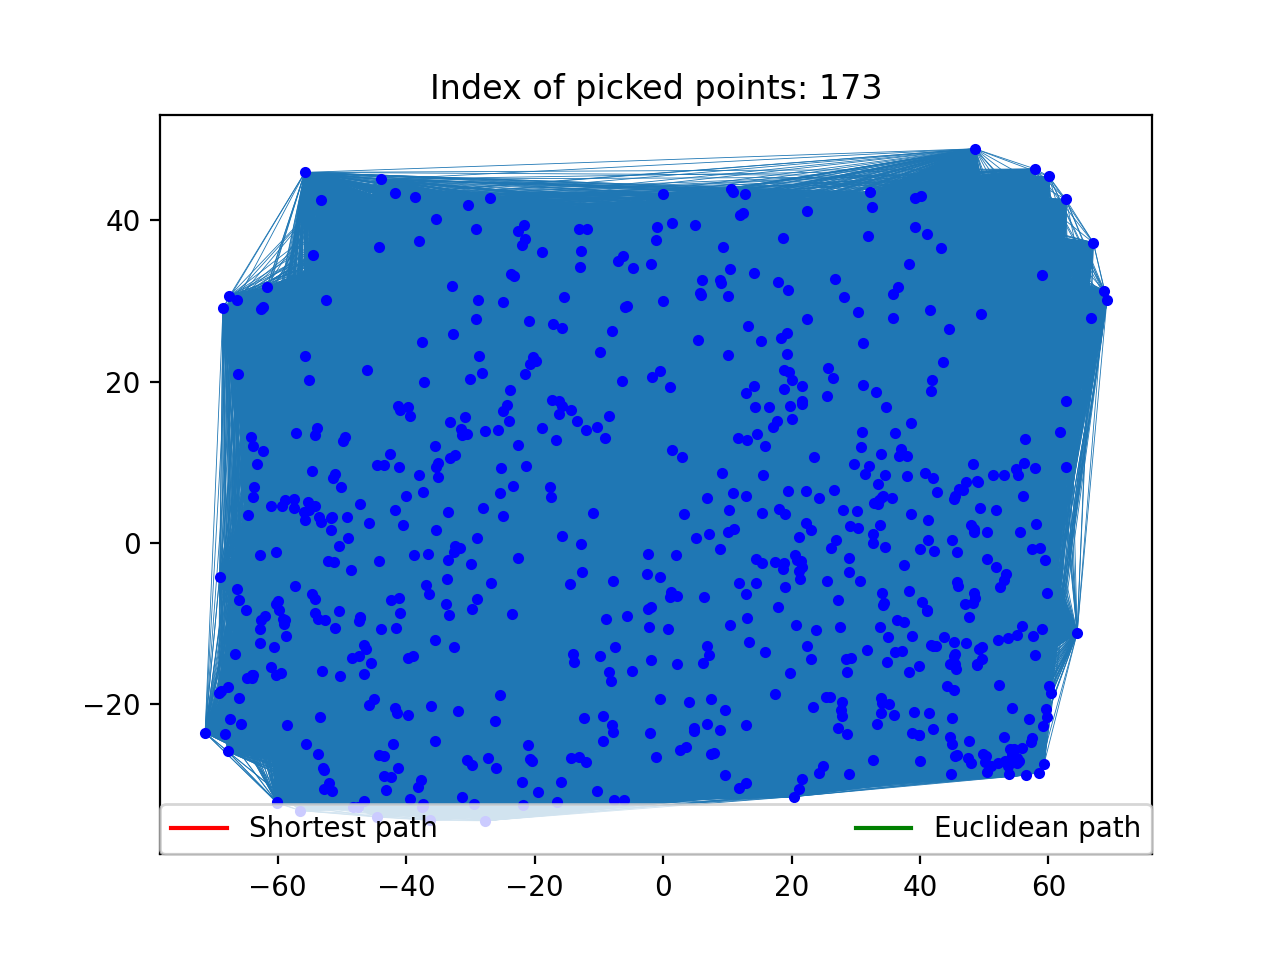

In [33]:
fig_face_index_h = plt.figure()
vis_face_index_h = VIS_Shortest_path_2d(Y_face, dist_face, predecessors_face, fig_face_index_h)

Path 1 indices: [1, 512, 444, 274, 169, 270, 507, 697]


<IPython.core.display.Javascript object>


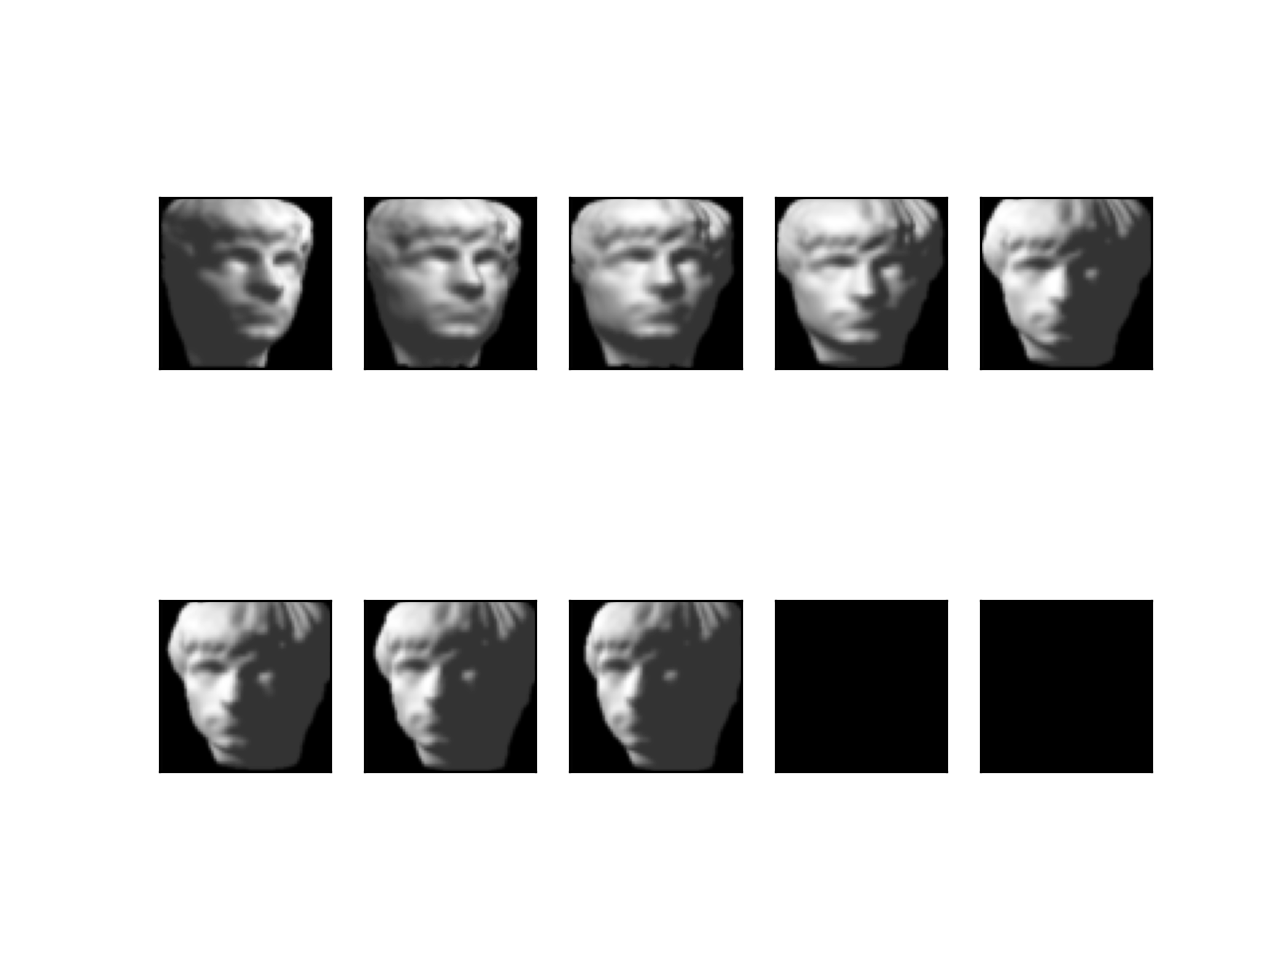

In [20]:
# Select start and end points for path 1
image_size = [64,64]
start_idx1, end_idx1 = 1, 697
path1 = get_shortest_path(predecessors_face, start_idx1, end_idx1)
print("Path 1 indices:", path1)

# Display images for path 1
fig_img1 = plt.figure()  # Create a figure for Path 1 images
viewer1 = ImageViewer(data_face, path1, image_size, fig_img1, 5)
viewer1.show()  # Display the images along the path

#### Path 2

<IPython.core.display.Javascript object>


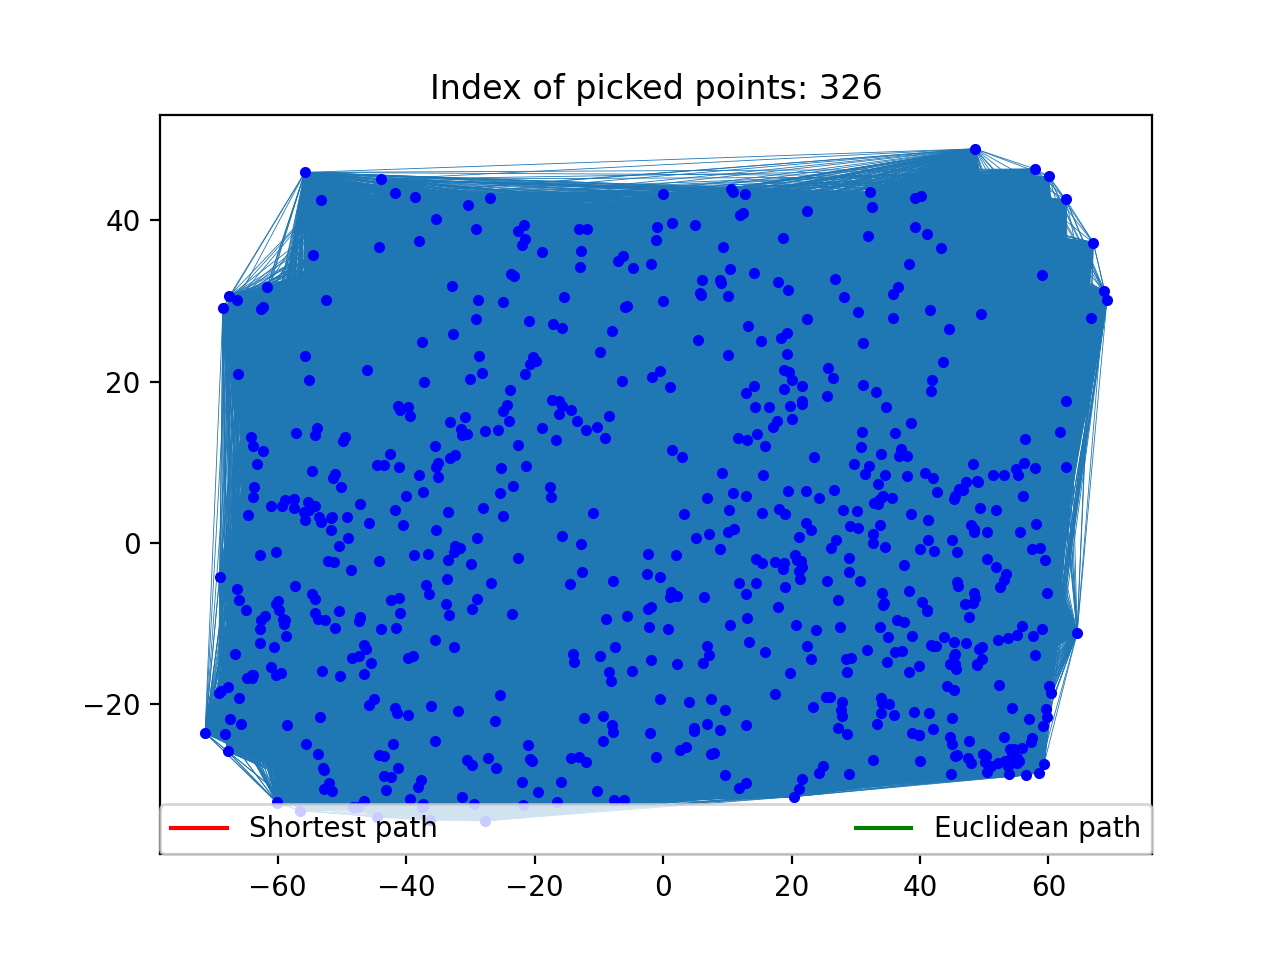

In [21]:
fig_face_index_v = plt.figure()
vis_face_index_v = VIS_Shortest_path_2d(Y_face, dist_face, predecessors_face, fig_face_index_v)

Path 2 indices: [30, 514, 478, 667, 22, 306, 586, 80]


<IPython.core.display.Javascript object>


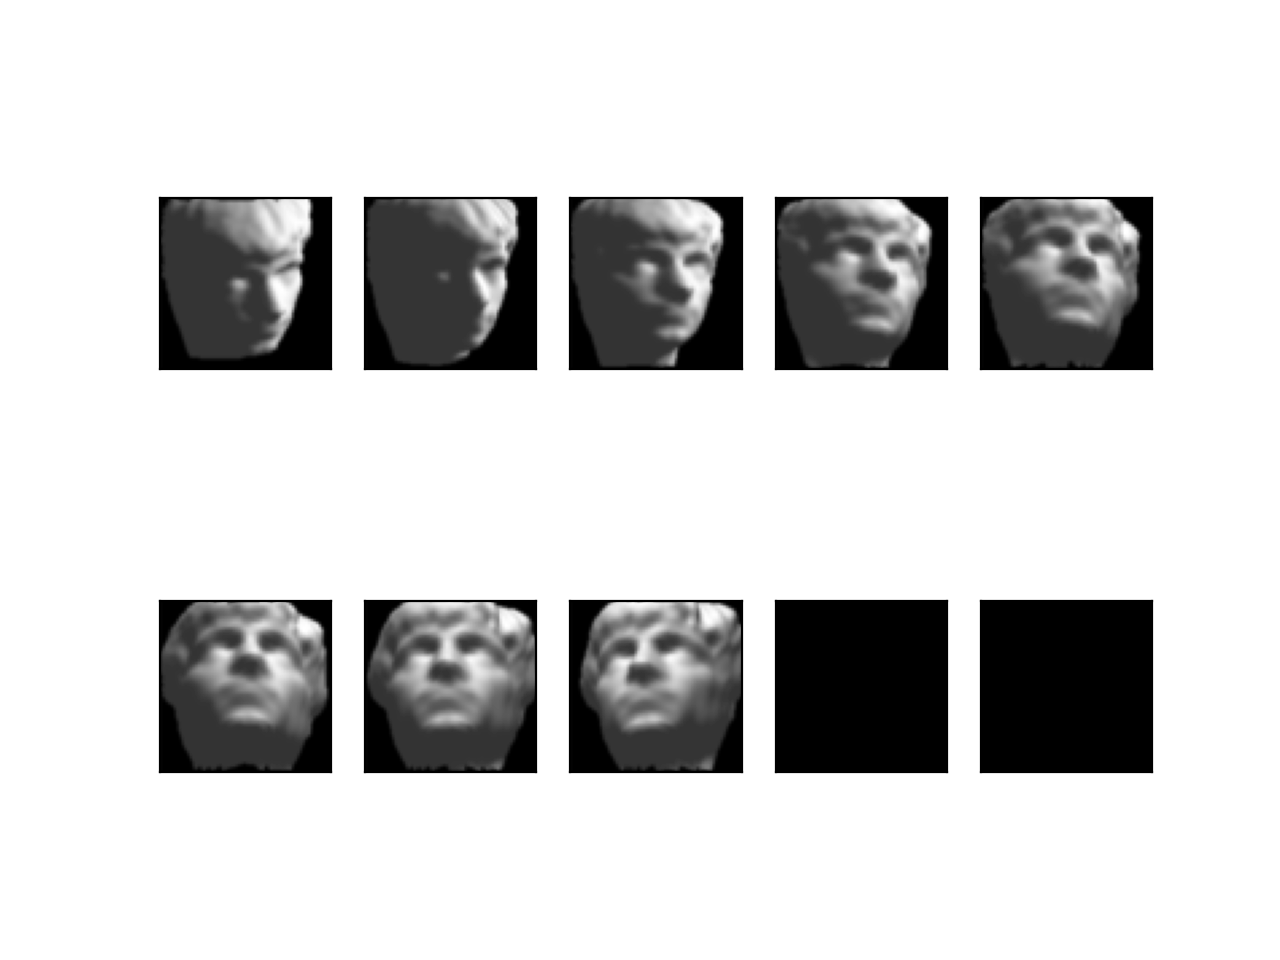

In [22]:
# Select start and end points for path 2
image_size = [64,64]
start_idx2, end_idx2 = 30, 80
path2 = get_shortest_path(predecessors_face, start_idx2, end_idx2)
print("Path 2 indices:", path2)

# Display images for path 2
fig_img2 = plt.figure()  # Create a figure for Path 2 images
viewer2 = ImageViewer(data_face, path2, image_size, fig_img2, 5)
viewer2.show()  # Display the images along the path


Assignment 5-(b): explain what you observe on those points in two paths in terms of manifold learning:

The images along Path 1 show smooth transitions in expression or orientation, reflecting the continuity of the underlying manifold.The path captures gradual, small changes between similar facial features, as expected in manifold learning.The changes from one face to the next in the path are small and gradual, consistent with the idea of a smooth manifold where nearby points (faces) represent similar facial structures or views.

The images along Path 2 involve more noticeable differences in facial features, such as pose or lighting.This path highlights larger variations while still following a continuous manifold structure.The path taken here (from 30 to 80) likely traverses regions of the manifold with more significant facial changes, such as lighting, pose, or expression. 

TBoth paths demonstrate how manifold learning captures smooth, meaningful transitions in high-dimensional data (faces) by preserving local relationships in a lower-dimensional space.Path 1 reflects subtle changes, while Path 2 represents larger differences.

### <span style="color:red">=========== End of Assignment 5 ===========</span>



## Part 3. Locally Linear Embedding (LLE) 

In [23]:
from Code.helpers import VIS_Bars
from Code.lle import lle

### <span style="color:red">============ Assignment 6 =========== </span>

In [24]:
from sklearn.datasets import make_s_curve
n_points = 1000
X, angle = make_s_curve(n_points, random_state=0)
X = X.T

<IPython.core.display.Javascript object>


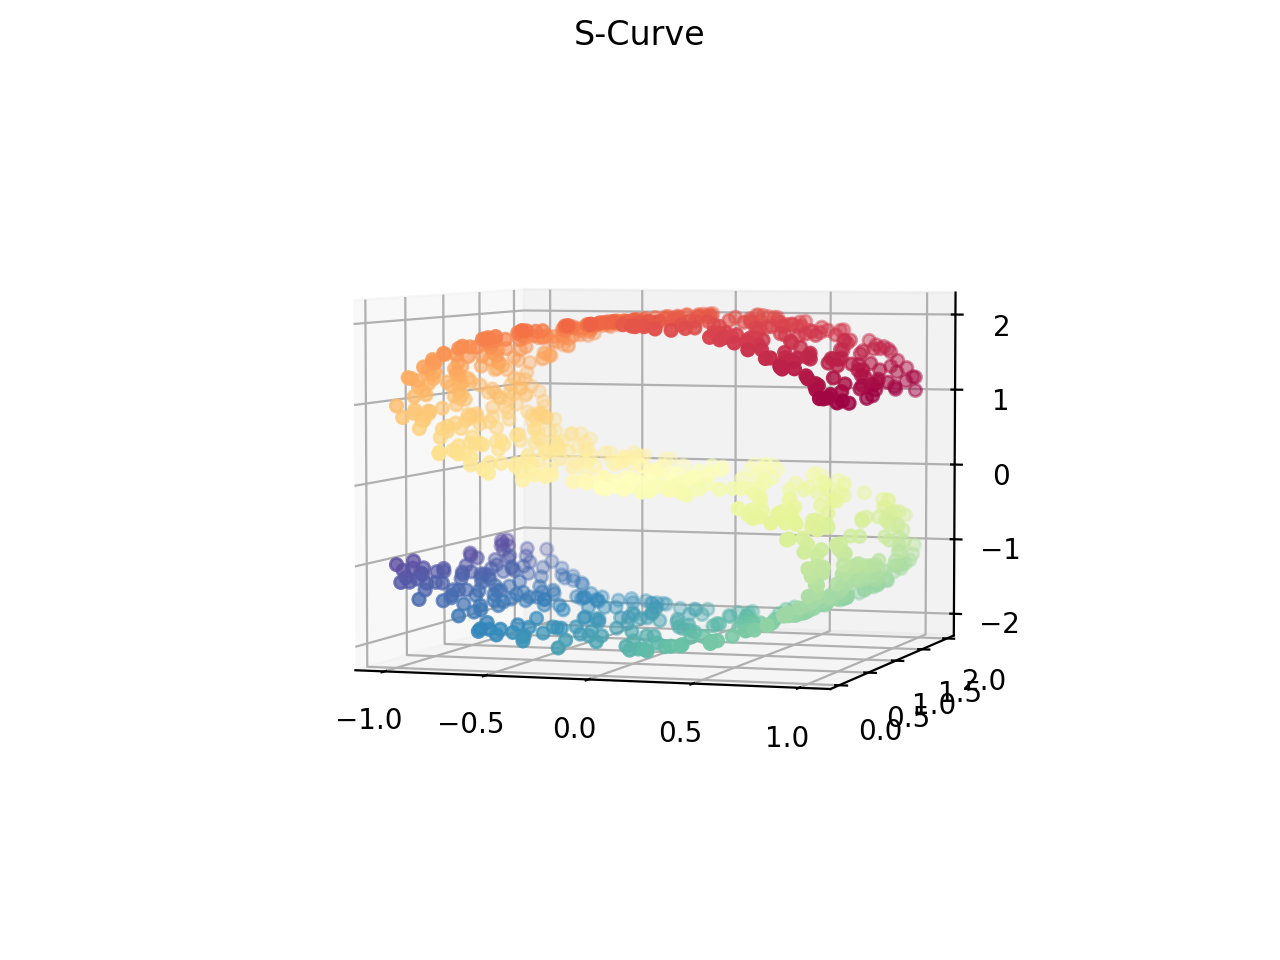

In [25]:
fig_s_curve = plt.figure()
fig_s_curve.suptitle('S-Curve')
    
colorize = dict(c=angle, cmap=plt.cm.Spectral)
# Add 3d scatter plot
ax = fig_s_curve.add_subplot(projection='3d')
ax.scatter(X[0,:], X[1,:], X[2,:], **colorize)
ax.view_init(4, -72)

Evaluating KNN method...
K          Reconstruction Error    Coverage    Sparsity    Combined Metric
----------------------------------------------------------------------
5          0.000378               1.000000   0.999200   1.000000  
6          0.000193               1.000000   0.999333   0.510920  
7          0.000125               1.000000   0.999286   0.330099  
8          0.000097               1.000000   0.999250   0.256599  
9          0.000086               1.000000   0.999111   0.227170  
10         0.000081               1.000000   0.999200   0.215080  
11         0.000078               1.000000   0.999273   0.206488  
12         0.000079               1.000000   0.999167   0.207711  
13         0.000077               1.000000   0.999231   0.204895  
14         0.000078               1.000000   0.999286   0.206023  
15         0.000077               1.000000   0.999333   0.202850  
16         0.000075               1.000000   0.999313   0.197525  
17         0.000072      

<IPython.core.display.Javascript object>


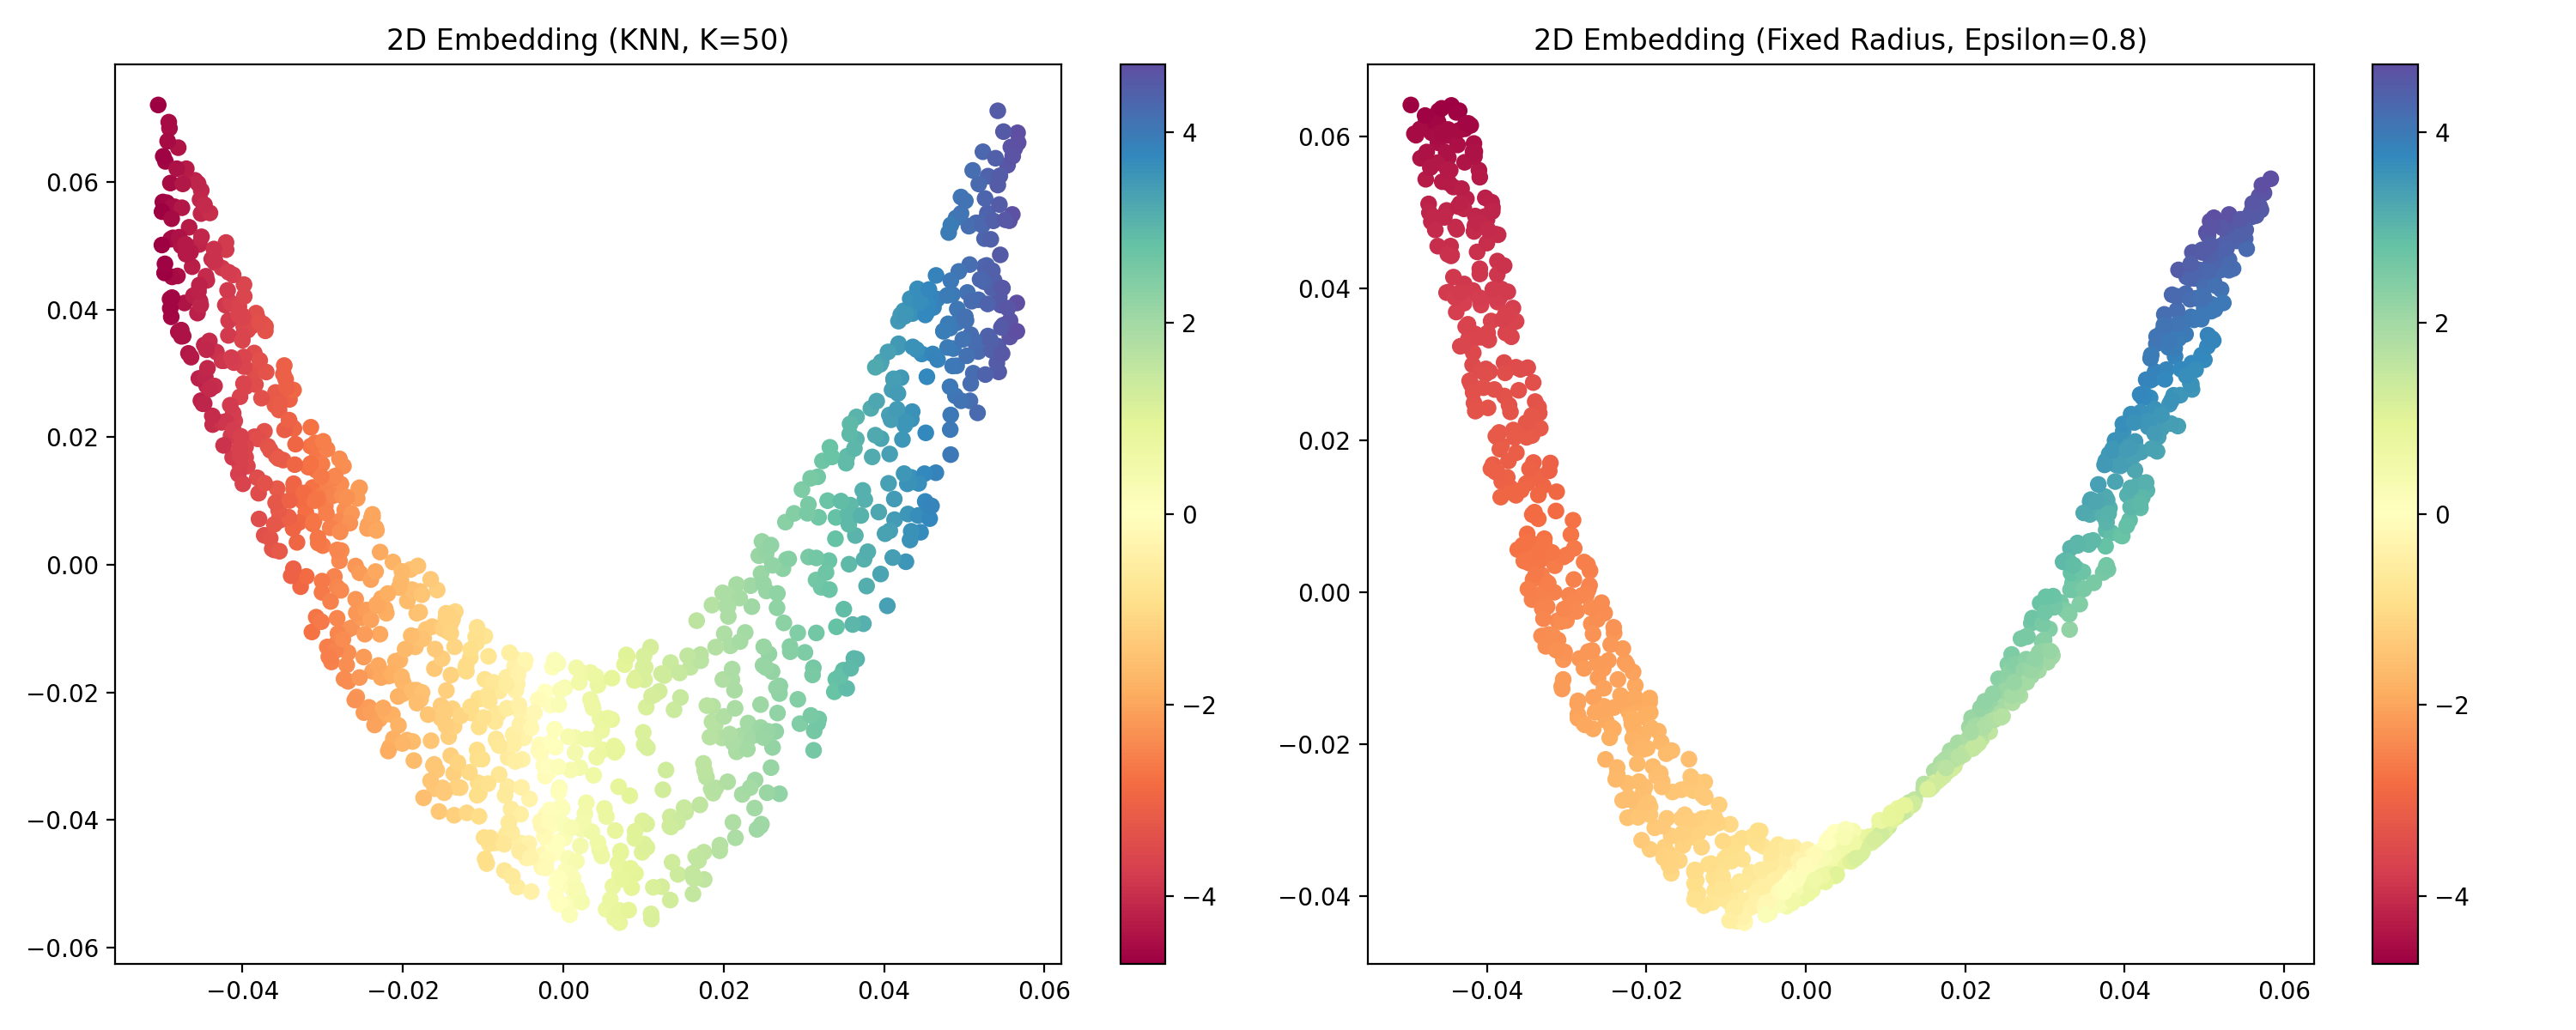

In [26]:
from sklearn.metrics import pairwise_distances  # pairwise_distances
from Code.lle import lle, get_weights, Y_  # Ensure direct import of get_weights and Y_

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, euclidean_distances
from Code.lle import lle, get_weights, Y_

# Reconstruction Error
def reconstruction_error(data, neighbors, weights):
    n = data.shape[1]
    error = 0
    for i in range(n):
        x_i = data[:, i]
        x_hat = np.sum(weights[i, neighbors[i]] * data[:, neighbors[i]], axis=1)
        error += np.linalg.norm(x_i - x_hat) ** 2
    return error / n

# Coverage
def calculate_coverage(data):
    coverage=np.sum([len(n) > 0 for n in data]) / len(data)
    return coverage

# Sparsity
def calculate_sparsity(data):
    total_elements = sum(len(n) for n in data)
    non_zero_elements = sum(sum(1 for x in n if x != 0) for n in data)
    sparsity = non_zero_elements / total_elements
    return sparsity


# Evaluation Function
def evaluate_method(data, method, param_range, param_name):
    errors = [1e-6]
    coverage_scores = [1e-6]
    sparsity_scores = [1e-6]

    min_combined_metric = float('inf')
    optimal_param = None
    
    print(f"Evaluating {method.upper()} method...")
    print(f"{param_name:<10} Reconstruction Error    Coverage    Sparsity    Combined Metric")
    print("-" * 70)
    
    for param in param_range:
        if method == 'knn':
            nbrs_dist, nbrs_idx = nearest_neighbor_distance(data, int(param))  
        elif method == 'epsilon':
            nbrs_dist, nbrs_idx = fixed_radius_distance(data, param)
        else:
            raise ValueError("Invalid method")

        Weights = get_weights(data, nbrs_idx)
        Y = Y_(Weights, 2)
        
        
        # Calculating metrics
        error = reconstruction_error(data, nbrs_idx, Weights)
        coverage = calculate_coverage(nbrs_idx) 
        sparsity = calculate_sparsity(nbrs_idx)
       

        errors.append(error)
        coverage_scores.append(coverage)
        sparsity_scores.append(sparsity)
        
        # Calculating comprehensive index
        combined_metric = (
            (error / max(errors)) - 
            (coverage / max(coverage_scores)) + 
            (sparsity / max(sparsity_scores))
        )
        
        if combined_metric < min_combined_metric:
            min_combined_metric = combined_metric
            optimal_param = param
        # Print the current parameter and metrics
        print(f"{param:<10} {error:<22.6f} {coverage:<10.6f} {sparsity:<10.6f} {combined_metric:<10.6f}")


    # Return after removing the initial value
    return optimal_param, errors[1:], coverage_scores[1:], sparsity_scores[1:]


#  Main Execution
k_values = range(5, 51, 1)  
epsilon_values = np.arange(0.1, 0.9, 0.1).astype(float)  

# Evaluate KNN
optimal_k, errors_knn, coverage_knn, sparsity_knn = evaluate_method(X, method='knn', param_range=k_values, param_name='K')

# Evaluate Fixed Radius
optimal_epsilon, errors_eps, coverage_eps, sparsity_eps = evaluate_method(X, method='epsilon', param_range=epsilon_values, param_name='Epsilon')

#report best
print("\n")
print(f"Find optimal K is: {optimal_k}")

print("\n")
print(f"Find optimal epsilon is: {optimal_epsilon}")

# Visualize Embeddings
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

# KNN Embedding
Y_knn = lle(X, n_components=2, n_neighbors=optimal_k, dist_func=nearest_neighbor_distance)
sc1 = axes[0].scatter(Y_knn[0, :], Y_knn[1, :], c=angle, cmap=plt.cm.Spectral)
axes[0].set_title(f"2D Embedding (KNN, K={optimal_k})")
plt.colorbar(sc1, ax=axes[0], orientation='vertical')  

# Fixed Radius Embedding
Y_eps = lle(X, n_components=2, epsilon=optimal_epsilon, dist_func=fixed_radius_distance)
sc2 = axes[1].scatter(Y_eps[0, :], Y_eps[1, :], c=angle, cmap=plt.cm.Spectral)
axes[1].set_title(f"2D Embedding (Fixed Radius, Epsilon={optimal_epsilon})")
plt.colorbar(sc2, ax=axes[1], orientation='vertical')  


plt.tight_layout()
plt.show()


【Assignment 6-a】describe a criterion that works ectively in finding out the optimal hyperparameters：

To determine the optimal hyperparameters K and epsilon for manifold learning, we use a criterion based on three metrics: reconstruction error, coverage, and sparsity. 
（1）Reconstruction error quantifies how well each data point can be reconstructed using its neighbors, with lower values indicating better preservation of local structure. 
（2）Coverage measures the proportion of points with at least one neighbor, ensuring no data points are isolated. 
（3）Sparsity reflects the average number of neighbors per point, promoting computational efficiency and avoiding overfitting or underfitting. 
By combining these metrics into a single measure—minimizing reconstruction error while maximizing coverage and balancing sparsity—we identify the parameter that best balances embedding accuracy, connectivity, and efficiency. This combined metric is calculated for a range of K and epsilon, and the parameter that minimizes it is selected as optimal.

### <span style="color:red">============ End of Assignment 6 =========== </span>

### <span style="color:red">============ Assignment 7 =========== </span>

In [27]:
from Code.dataset import bars

data_bar, centers = bars()
data_bar = data_bar.T
centers = centers.T
image_size = [40,40]

In [28]:
def reg_func(C, K):
    trace = np.trace(C)
    return 1e-3*trace*K*np.eye(K)

Evaluating KNN method...
K          Reconstruction Error    Coverage    Sparsity    Combined Metric
----------------------------------------------------------------------
41         178217.237041          1.000000   0.999195   1.000000  
42         177609.733650          1.000000   0.999167   0.996563  
43         176941.796998          1.000000   0.999186   0.992834  
44         176281.782413          1.000000   0.999205   0.989140  
45         175714.439596          1.000000   0.999200   0.985952  
46         175279.450673          1.000000   0.999217   0.983516  
47         174783.989316          1.000000   0.999234   0.980736  
48         174313.602992          1.000000   0.999229   0.978091  
49         173803.309703          1.000000   0.999224   0.975223  
50         173335.796303          1.000000   0.999240   0.972610  
51         172929.966715          1.000000   0.999196   0.970288  
52         172591.819189          1.000000   0.999212   0.968407  
53         172322.155627 

<IPython.core.display.Javascript object>


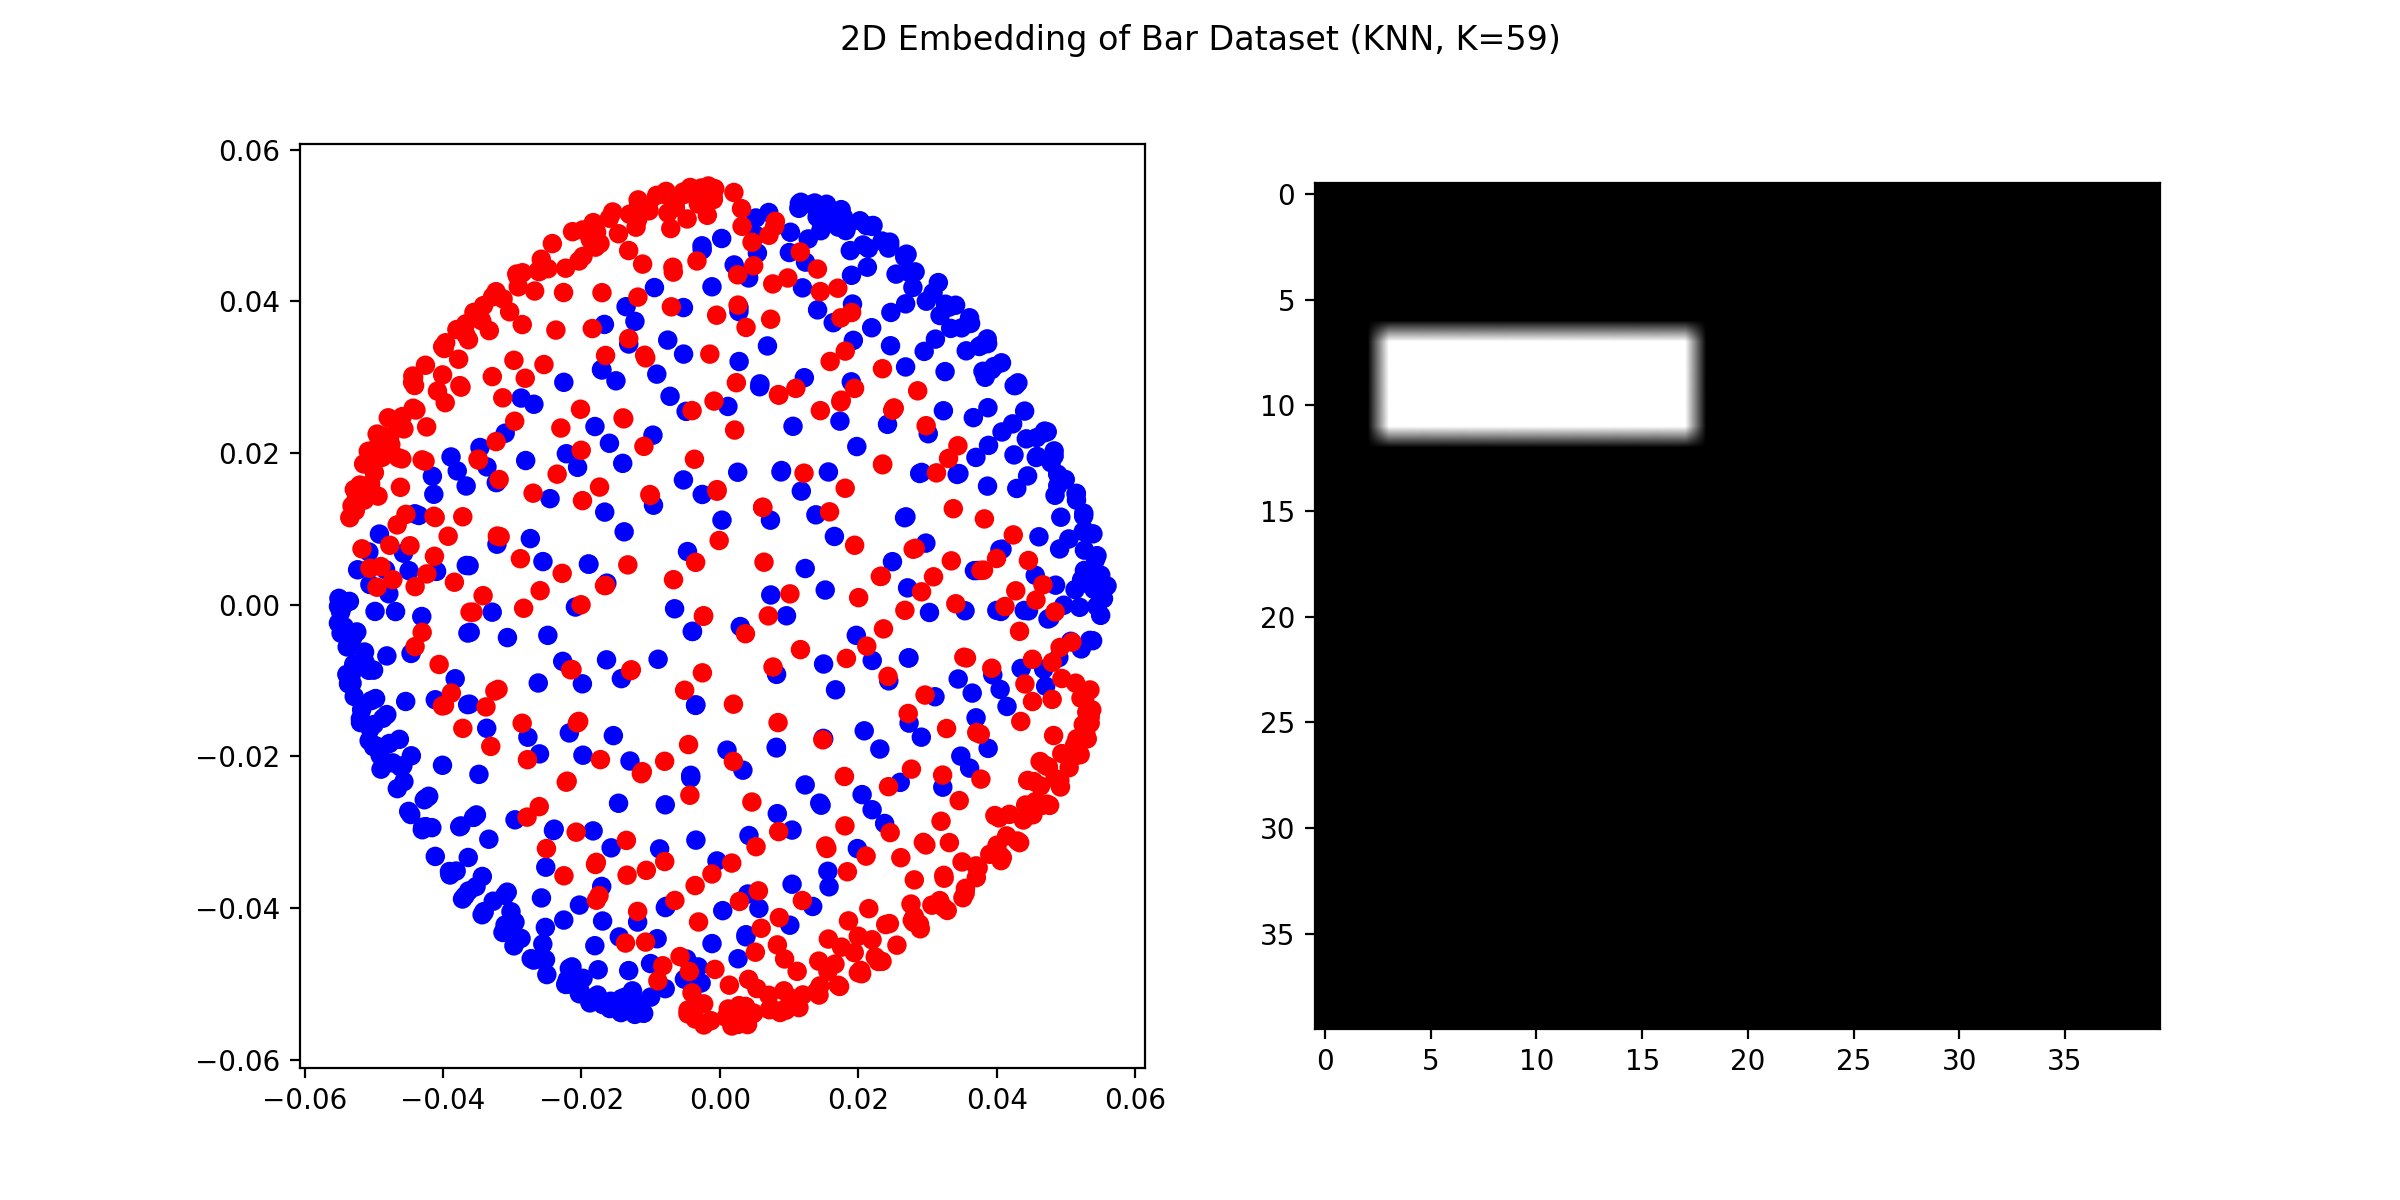

In [29]:
# Range for K
k_values = range(41, 60)
errors = []

# Evaluate reconstruction error for each K
for k in k_values:
    nbrs_dist, nbrs_idx = nearest_neighbor_distance(data_bar, k)
    weights = get_weights(data_bar, nbrs_idx, reg_func=reg_func)
    error = reconstruction_error(data_bar, nbrs_idx, weights)
    errors.append(error)

# Optimal K
# Evaluate for optimal K using the provided evaluate_method function
optimal_k7, errors, coverage_scores, sparsity_scores = evaluate_method(
    data=data_bar, 
    method='knn', 
    param_range=k_values, 
    param_name='K'
)

print("\n")
print(f"Find optimal K is: {optimal_k7}")

# Apply LLE with optimal K
Y_knn_bar = lle(data=data_bar,n_components=2,n_neighbors=optimal_k7,dist_func=nearest_neighbor_distance,reg_func=reg_func)

# Visualize embedding
fig_bars = plt.figure(figsize=(12, 6))
fig_bars.suptitle(f"2D Embedding of Bar Dataset (KNN, K={optimal_k7})")
vis = VIS_Bars(data=data_bar, proj=Y_knn_bar, fig_vis=fig_bars, image_size=image_size)
plt.show()

【Assignment 7-(c)】 describe what you observe from those embedded coordinates in terms
of manifold learning
The 2D embedding of the bar dataset reveals a clear separation between the two classes: vertical and horizontal bars, with points representing similar patterns clustering together. This demonstrates that LLE effectively captures the intrinsic structure of the data by preserving local neighborhood relationships in the reduced-dimensional space. The smooth transitions within each class highlight the preservation of local geometry, facilitated by the optimal K. Additionally, the use of the regularization function ensures smooth and robust embeddings, while sparsity maintains computational efficiency. Overall, the embedding illustrates how manifold learning preserves the intrinsic geometry of high-dimensional data.

### <span style="color:red">============ End of Assignment 7 =========== </span>